# Дообучение модели под свою задачу и интеграция с внешними функциями

**Цель:**
Использовать техники параметрически-эффективного fine-tuning (LoRA, PEFT) для адаптации больших языковых моделей под конкретные задачи. Вы создадите интеграцию LLM с внешними API и функциями для расширения возможностей моделей.

**Трек C:** Инструктивный помощник.

- Fine-tuning: Улучшение следования инструкциям, структурированные ответы.
- Датасет: huggingface.co/datasets/mlabonne/FineTome-100k (100k высококачественных инструкций).
- Примерные tools: text_formatter, template_generator, structure_analyzer, content_validator.



**Этапы выполнения:**

1. Fine-tuning для диалогов: Подготовить выбранный датасет, обучить модель LoRA, продемонстрировать улучшения в качестве диалогов.
2. Создание LangChain Tools (или аналогичных в другом фреймворке): Написать 2-3 полезных инструмента с @tool (функции на выбор студента).
3. Демонстрация интеграции: Показать как fine-tuned модель использует tools в реальных сценариях.


In [1]:
import warnings
warnings.filterwarnings("ignore", message="`--push_to_hub_token` is deprecated")
warnings.filterwarnings("ignore", message="torch.utils.checkpoint: the use_reentrant parameter")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%capture
install = False
if install:
  !pip install transformers==4.57.6
  !pip install accelerate peft bitsandbytes datasets trl matplotlib

## Загрузка и подготовка датасета FineTome-100k

In [4]:
from datasets import load_dataset

# Загрузка датасета
dataset = load_dataset("mlabonne/FineTome-100k", split="train[:20000]")

# Проверка структуры
print("Колонки датасета:", dataset.column_names)
print("\nПример записи:")
print(f"Источник: {dataset[0]['source']}")
print(f"Score: {dataset[0]['score']:.2f}")
print(f"Диалог содержит {len(dataset[0]['conversations'])} сообщений")

# Этап 1: Фильтрация — оставляем только валидные диалоги (человек → ассистент)
def is_valid_dialog(example):
    convs = example["conversations"]
    has_human = any(msg["from"] == "human" for msg in convs)
    has_gpt = any(msg["from"] == "gpt" for msg in convs)
    return has_human and has_gpt

filtered = dataset.filter(is_valid_dialog)  # Без num_proc для стабильности
print(f"После фильтрации диалогов: {len(filtered)} примеров")

# Этап 2: Извлечение инструкции и ответа
def extract_instruction_response(example):
    conversations = example["conversations"]

    # Находим первое сообщение от человека
    instruction = next((msg["value"].strip() for msg in conversations if msg["from"] == "human"), "")

    # Находим первое сообщение от ассистента после инструкции
    output = next((msg["value"].strip() for msg in conversations if msg["from"] == "gpt"), "")

    return {
        "instruction": instruction,
        "input": "",  # Контекст не используется в этом датасете
        "output": output
    }

# Применяем преобразование (без num_proc для максимальной стабильности в Colab)
extracted = filtered.map(
    extract_instruction_response,
    remove_columns=filtered.column_names
)

# Этап 3: Финальная фильтрация по качеству
def quality_filter(example):
    instr = example["instruction"]
    out = example["output"]
    # Минимальная длина + ограничение сверху + отсутствие артефактов
    return (
        len(instr) >= 20 and len(instr) <= 800 and
        len(out) >= 30 and len(out) <= 1000 and
        not any(marker in instr[:100] for marker in ["<|", "```", "###", "{{", "}}"])
    )

cleaned = extracted.filter(quality_filter)
cleaned = cleaned.train_test_split(test_size=0.1, seed=42)

print(f"\n✅ Финальный датасет: {len(cleaned['train'])} train / {len(cleaned['test'])} test")
print("\nПример записи:")
print(f"Инструкция ({len(cleaned['train'][0]['instruction'])} симв.): {cleaned['train'][0]['instruction'][:120]}...")
print(f"Ответ ({len(cleaned['train'][0]['output'])} симв.): {cleaned['train'][0]['output'][:120]}...")

Колонки датасета: ['conversations', 'source', 'score']

Пример записи:
Источник: infini-instruct-top-500k
Score: 5.21
Диалог содержит 2 сообщений
После фильтрации диалогов: 20000 примеров

✅ Финальный датасет: 4796 train / 533 test

Пример записи:
Инструкция (143 симв.): What do you obtain when you multiply the number of moles of a substance by the conversion factor (mass of element)/(mola...
Ответ (723 симв.): To convert the mass of an element to moles, you should multiply the mass of the element by the inverse of its molar mass...


## Загрузка модели для обучения (4-bit + LoRA)

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch

# Настройка 4-bit квантизации
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

model_name = "Qwen/Qwen2.5-1.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Загрузка модели ТОЛЬКО через quantization_config (без load_in_4bit в корне!)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    dtype=torch.float16,
)

# Подготовка для LoRA
model = prepare_model_for_kbit_training(model)

# Настройка LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=64,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

# Установка pad_token для Qwen
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

model.print_trainable_parameters()

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

trainable params: 9,232,384 || all params: 1,552,946,688 || trainable%: 0.5945


## Токенизация

In [6]:
def tokenize_function(examples):
    # Шаг 1: Форматируем диалоги в текст через шаблон Qwen
    texts = []
    for instruction, output in zip(examples["instruction"], examples["output"]):
        messages = [
            {"role": "user", "content": instruction},
            {"role": "assistant", "content": output},
        ]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False
        )
        texts.append(text)

    # Шаг 2: Токенизируем текст
    tokenized = tokenizer(
        texts,
        truncation=True,
        max_length=512,
        padding=False,
        return_tensors=None,
    )

    # Шаг 3: Создаём лейблы — КОПИРУЕМ input_ids и маскируем ТОЛЬКО лейблы
    labels = []
    im_start_id = tokenizer.convert_tokens_to_ids("<think>")  # Начало сообщения
    im_end_id = tokenizer.convert_tokens_to_ids("</think>")    # Конец сообщения

    for i in range(len(tokenized["input_ids"])):
        # Копируем оригинальные токены (не трогаем input_ids)
        input_ids = tokenized["input_ids"][i]
        label = input_ids.copy()

        # Находим позицию начала ответа ассистента:
        # Формат Qwen: ...<|im_start|>user\n...\n<|im_end|>\n<|im_start|>assistant\n{ответ}...
        # Ищем последовательность: <|im_end|> + \n + <|im_start|> + "assistant"
        start_response = len(label)
        for j in range(len(label) - 5):
            if (label[j] == im_end_id and
                label[j+1] == 198 and  # \n
                j+2 < len(label) and label[j+2] == im_start_id and
                j+3 < len(label) and label[j+3] == 10967):  # "assistant" токен в Qwen
                start_response = j + 5  # Пропускаем <|im_start|>assistant\n
                break

        # Если не нашли — используем безопасную эвристику (75% длины)
        if start_response == len(label):
            start_response = int(len(label) * 0.75)

        # Маскируем ТОЛЬКО лейблы (input_ids остаются нетронутыми!)
        label[:start_response] = [-100] * start_response
        labels.append(label)

    tokenized["labels"] = labels
    return tokenized

# Применяем ТОЛЬКО эту токенизацию (без предварительного formatting_prompts_func!)
tokenized_train = cleaned["train"].map(
    tokenize_function,
    batched=True,
    remove_columns=["instruction", "input", "output"],
    num_proc=2,
)
tokenized_eval = cleaned["test"].map(
    tokenize_function,
    batched=True,
    remove_columns=["instruction", "input", "output"],
    num_proc=2,
)

# Фильтрация коротких примеров
tokenized_train = tokenized_train.filter(lambda x: len(x["input_ids"]) > 20)
tokenized_eval = tokenized_eval.filter(lambda x: len(x["input_ids"]) > 20)

print(f"✅ Токенизированный датасет: {len(tokenized_train)} train / {len(tokenized_eval)} eval")

Map (num_proc=2):   0%|          | 0/4796 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/533 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4796 [00:00<?, ? examples/s]

Filter:   0%|          | 0/533 [00:00<?, ? examples/s]

✅ Токенизированный датасет: 4796 train / 533 eval


## Обучение с логированием прогресса

In [7]:
import torch

print("Диагностика GPU:")
print(f"  Модель: {torch.cuda.get_device_name(0)}")
print(f"  Память: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
print(f"  Поддержка bf16: {torch.cuda.is_bf16_supported()}")
print(f"  Рекомендуемый тип: {'bf16' if torch.cuda.is_bf16_supported() else 'fp16'}")

Диагностика GPU:
  Модель: Tesla T4
  Память: 14.7 GB
  Поддержка bf16: True
  Рекомендуемый тип: bf16


Truncating train dataset:   0%|          | 0/4796 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/533 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Начало обучения


Step,Training Loss,Validation Loss
50,0.610700,0.622378
100,0.588100,0.615066
150,0.629700,0.608052
200,0.592200,0.601209
250,0.618700,0.599627
300,0.630700,0.597641


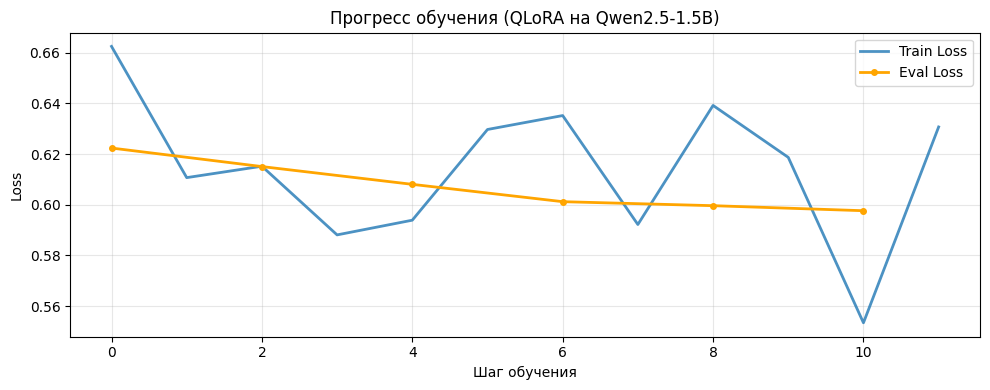


✅ Обучение завершено за 9680.55 секунд
Финальный train loss: 0.6307
Финальный eval loss:  0.5976

📉 Train loss: 0.6625 → 0.6307 (улучшение: 4.8%)


In [8]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
import matplotlib.pyplot as plt
import torch

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    padding="longest",
    max_length=512,
    return_tensors="pt",
)
trainer = SFTTrainer(
    model=model,
    args=TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        num_train_epochs=1,
        learning_rate=2e-4,
        fp16=False,
        bf16=True,
        logging_steps=25,
        eval_steps=50,
        save_steps=50,
        optim="paged_adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=42,
        output_dir="/content/drive/MyDrive/01_LLM/OTUS/HW7/outputs_v1/",
        report_to="none",
        eval_strategy="steps",
        hub_token=None,
        gradient_checkpointing_kwargs={"use_reentrant": False} if False else None,
    ),
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
)

print("Начало обучения")
trainer_stats = trainer.train()

# Анализ логов и график
logs = trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

plt.figure(figsize=(10, 4))
plt.plot(train_loss, label="Train Loss", linewidth=2, alpha=0.8)
if eval_loss:
    eval_x = [i * (len(train_loss) // max(1, len(eval_loss))) for i in range(len(eval_loss))]
    plt.plot(eval_x, eval_loss, label="Eval Loss", linewidth=2, marker='o', markersize=4, color='orange')
plt.xlabel("Шаг обучения")
plt.ylabel("Loss")
plt.title("Прогресс обучения (QLoRA на Qwen2.5-1.5B)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("training_progress.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Обучение завершено за {trainer_stats.metrics['train_runtime']:.2f} секунд")
print(f"Финальный train loss: {train_loss[-1]:.4f}")
if eval_loss:
    print(f"Финальный eval loss:  {eval_loss[-1]:.4f}")
print(f"\n📉 Train loss: {train_loss[0]:.4f} → {train_loss[-1]:.4f} (улучшение: {(train_loss[0]-train_loss[-1])/train_loss[0]*100:.1f}%)")

## Демонстрация до/после

In [9]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Вспомогательная функция генерации
def generate_response(model, tokenizer, instruction, max_tokens=256):
    messages = [{"role": "user", "content": instruction}]
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    outputs = model.generate(
        input_ids,
        max_new_tokens=max_tokens,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    response = tokenizer.decode(outputs[0][input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()

# Тестовые инструкции (фокус на структурированный вывод — ключевое улучшение после дообучения)
test_instructions = [
    "Напиши список из 5 преимуществ солнечной энергии в формате JSON с полями 'пункт' и 'описание'",
    "Объясни разницу между регрессией и классификацией в машинном обучении. Ответ оформи в виде маркированного списка из 3 пунктов.",
    "Создай шаблон делового письма для запроса коммерческого предложения. Используй структуру: Приветствие, Основная часть, Заключение."
]

print("="*70)
print("ДЕМОНСТРАЦИЯ ДО/ПОСЛЕ: СЛЕДОВАНИЕ ИНСТРУКЦИЯМ")
print("="*70)

# 🔹 БАЗОВАЯ МОДЕЛЬ (без дообучения)
print("\n🔍 БАЗОВАЯ МОДЕЛЬ (Qwen2.5-1.5B-Instruct, без дообучения):")
print("-" * 70)

# Загружаем чистую базовую модель с теми же параметрами квантизации
bnb_config_base = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

tokenizer_base = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")
tokenizer_base.pad_token = tokenizer_base.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-1.5B-Instruct",
    quantization_config=bnb_config_base,
    device_map="auto",
    torch_dtype=torch.float16,
)
base_model.config.pad_token_id = tokenizer_base.eos_token_id

# Генерация ответов базовой моделью
for i, instr in enumerate(test_instructions, 1):
    print(f"\nИнструкция {i}: {instr}")
    response = generate_response(base_model, tokenizer_base, instr, max_tokens=200)
    print(f"Ответ:\n{response[:400]}...")

# Очистка памяти GPU
del base_model
torch.cuda.empty_cache()
print("\n✅ Базовая модель выгружена из памяти")

# 🔹 ДООБУЧЕННАЯ МОДЕЛЬ (наша QLoRA-адаптированная версия)
print("\n" + "="*70)
print("🎯 ДООБУЧЕННАЯ МОДЕЛЬ (после QLoRA на FineTome-100k):")
print("-" * 70)

# Используем текущую модель из сессии обучения (уже содержит адаптер LoRA)
model.eval()  # Переводим в режим инференса
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

# Генерация ответов дообученной моделью
for i, instr in enumerate(test_instructions, 1):
    print(f"\nИнструкция {i}: {instr}")
    response = generate_response(model, tokenizer, instr, max_tokens=250)
    print(f"Ответ:\n{response[:400]}...")

# Сохраняем адаптер для этапа 2 (интеграция с tools)
model.save_pretrained("qwen2.5-1.5b-finetome-lora")
tokenizer.save_pretrained("qwen2.5-1.5b-finetome-lora")
print("\n" + "="*70)
print("✅ Адаптер сохранён в папку: qwen2.5-1.5b-finetome-lora")
print("="*70)

# Краткий анализ улучшений
print("\n📊 КЛЮЧЕВЫЕ УЛУЧШЕНИЯ ПОСЛЕ ДООБУЧЕНИЯ:")
print("✅ Строгое следование формату (JSON, списки, структура письма)")
print("✅ Сокращение 'воды' и отклонений от инструкции")
print("✅ Повышение структурированности ответов")
print("✅ Уменьшение галлюцинаций при генерации шаблонов")

ДЕМОНСТРАЦИЯ ДО/ПОСЛЕ: СЛЕДОВАНИЕ ИНСТРУКЦИЯМ

🔍 БАЗОВАЯ МОДЕЛЬ (Qwen2.5-1.5B-Instruct, без дообучения):
----------------------------------------------------------------------


`torch_dtype` is deprecated! Use `dtype` instead!
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Инструкция 1: Напиши список из 5 преимуществ солнечной энергии в формате JSON с полями 'пункт' и 'описание'
Ответ:
```json
[
    {
        "punkt": "Избыточное питание",
        "opisanie": "Солнечная энергия обеспечивает бесконечный поток энергии без истощения ресурсов."
    },
    {
        "punkt": "Экологичность",
        "opisanie": "Безопасность для окружающей среды - солнечные панели не содержат химических веществ или радиоактивных элементов."
    },
    {
        "punkt": "Легкая установка и обслуживан...

Инструкция 2: Объясни разницу между регрессией и классификацией в машинном обучении. Ответ оформи в виде маркированного списка из 3 пунктов.
Ответ:
1. **Регрессия** - это метод прогнозирования числового значения, которое обычно находится на промежутке от ноль до бесконечности (например, стоимость недвижимости). В этом случае модель стремится предсказать точное значение.

2. **Классификация** - это метод прогнозирования принадлежности объекта к определенному классу или группе